In [213]:
import pandas as pd
import matplotlib.pyplot as plt

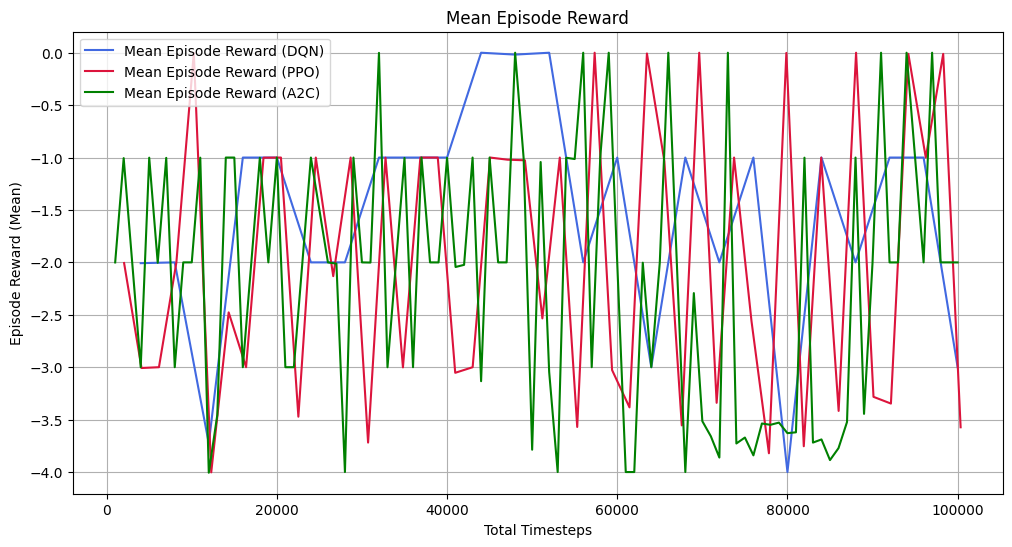

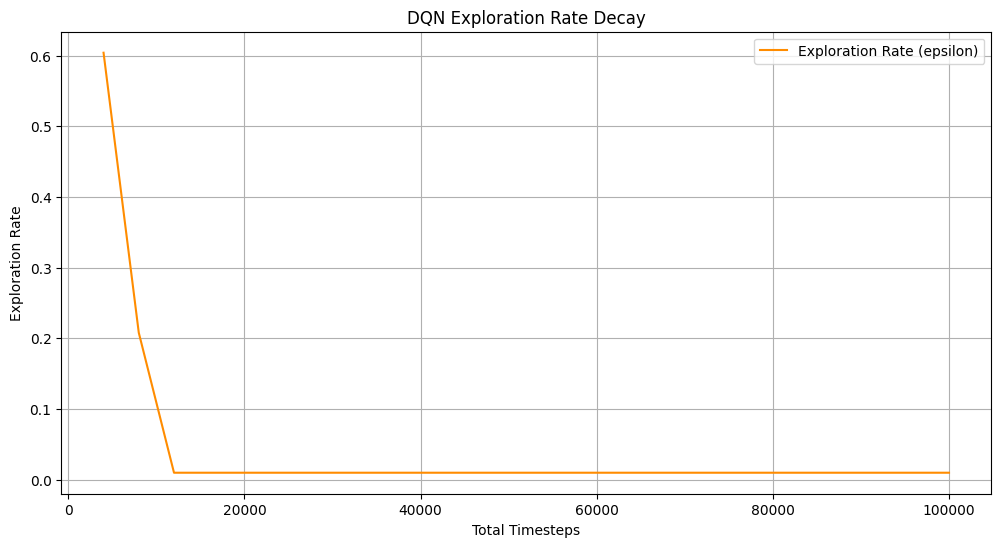

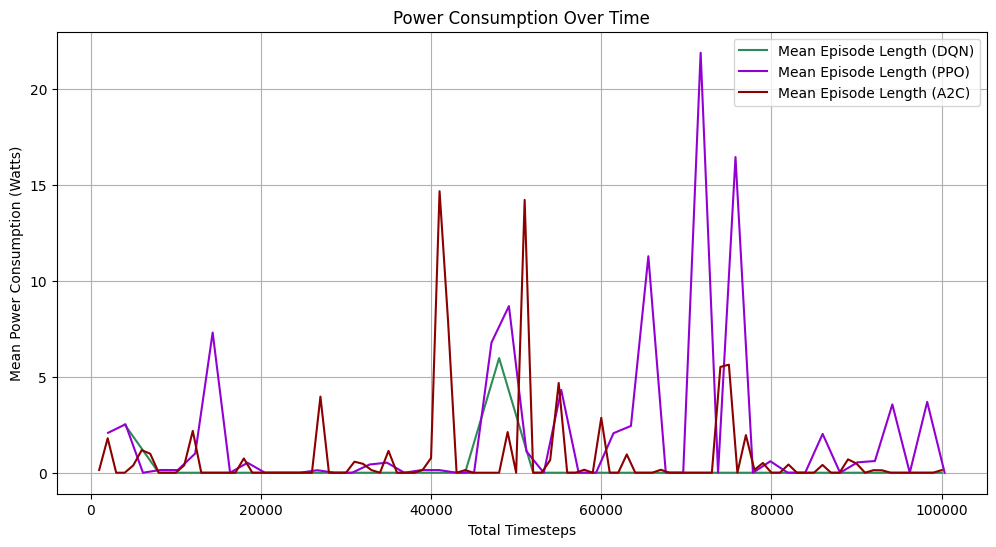

In [215]:
logs_dqn =  pd.read_csv('./dqn/logs/progress.csv')
logs_ppo = pd.read_csv('./ppo/logs/progress.csv')
logs_a2c = pd.read_csv('./a2c/logs/progress.csv')
logs_a2c.dropna(inplace=True)

# Plot: Mean Episode Reward vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_dqn['time/total_timesteps'], logs_dqn['env/reward'], label='Mean Episode Reward (DQN)', color='royalblue')
plt.plot(logs_ppo['time/total_timesteps'], logs_ppo['env/reward'], label='Mean Episode Reward (PPO)', color='crimson')
plt.plot(logs_a2c['time/total_timesteps'], logs_a2c['env/reward'], label='Mean Episode Reward (A2C)', color='green')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Reward (Mean)')
plt.title('Mean Episode Reward')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Exploration Rate vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_dqn['time/total_timesteps'], logs_dqn['rollout/exploration_rate'], label='Exploration Rate (epsilon)', color='darkorange')
plt.xlabel('Total Timesteps')
plt.ylabel('Exploration Rate')
plt.title('DQN Exploration Rate Decay')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Episode Length vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_dqn['time/total_timesteps'], logs_dqn['env/power'], label='Mean Episode Length (DQN)', color='seagreen')
plt.plot(logs_ppo['time/total_timesteps'], logs_ppo['env/power'], label='Mean Episode Length (PPO)', color='darkviolet')
plt.plot(logs_a2c['time/total_timesteps'], logs_a2c['env/power'], label='Mean Episode Length (A2C)', color='darkred')
plt.xlabel('Total Timesteps')
plt.ylabel('Mean Power Consumption (Watts)')
plt.title('Power Consumption Over Time')
plt.grid(True)
plt.legend()
plt.show()


In [216]:
print(f"Average DQN Fan Speed {logs_dqn['env/fan_speed'].mean():.4f}")
print(f"Average PPO Fan Speed {logs_ppo['env/fan_speed'].mean():.4f}")
print(f"Average A2C Fan Speed {logs_a2c['env/fan_speed'].mean():.4f}")

Average DQN Fan Speed -0.8341
Average PPO Fan Speed -13.7361
Average A2C Fan Speed -6.5552


In [217]:
## Calculate the average reward for each algorithm
avg_reward_dqn = logs_dqn['env/reward'].mean()
avg_reward_ppo = logs_ppo['env/reward'].mean()
avg_reward_a2c = logs_a2c['env/reward'].mean()
print(f"Average Reward DQN: {avg_reward_dqn}")
print(f"Average Reward PPO: {avg_reward_ppo}")
print(f"Average Reward A2C: {avg_reward_a2c}")

Average Reward DQN: -1.55009772496
Average Reward PPO: -1.962251194647959
Average Reward A2C: -2.142251573722222


In [218]:
## Calculate the average power consumption for each algorithm
avg_power_dqn = logs_dqn['env/power'].mean()
avg_power_ppo = logs_ppo['env/power'].mean()
avg_power_a2c = logs_a2c['env/power'].mean()
print(f"Average Power Consumption DQN: {avg_power_dqn} Watts")
print(f"Average Power Consumption PPO: {avg_power_ppo} Watts")
print(f"Average Power Consumption A2C: {avg_power_a2c} Watts")


Average Power Consumption DQN: 0.3392400385476706 Watts
Average Power Consumption PPO: 2.0633211580417323 Watts
Average Power Consumption A2C: 0.8043972070117914 Watts


In [219]:
## Calculate the average AQI for each algorithm
avg_aqi_dqn = logs_dqn['env/aqi'].mean()
avg_aqi_ppo = logs_ppo['env/aqi'].mean()
avg_aqi_a2c = logs_a2c['env/aqi'].mean()
print(f"Average AQI DQN: {avg_aqi_dqn}")
print(f"Average AQI PPO: {avg_aqi_ppo}")
print(f"Average AQI A2C: {avg_aqi_a2c}")

Average AQI DQN: 2.54908
Average AQI PPO: 2.956061224489796
Average AQI A2C: 3.139838383838384


In [196]:

import sys
import os
from stable_baselines3 import PPO, DQN, A2C
from simulated.environment import FanControlGymEnv
import time
from simulated.physics import FanControlEnv
import matplotlib.pyplot as plt
import numpy as np

In [197]:

# 1. Load Environment and Model
fan_env = FanControlEnv()
env = FanControlGymEnv(fan_env=fan_env)

In [210]:
CHECKPOINT_DIR_DQN = './dqn/train'
CHECKPOINT_DIR_PPO = './ppo/train'
CHECKPOINT_DIR_A2C = './a2c/train'

In [211]:
# Define ranges
aqi_range = np.linspace(1.0, 5.0, 20)
# Truncate fan speeds below 0.53
speed_range = np.linspace(0, 1.0, 20)
action_grid = np.zeros((len(aqi_range), len(speed_range)))

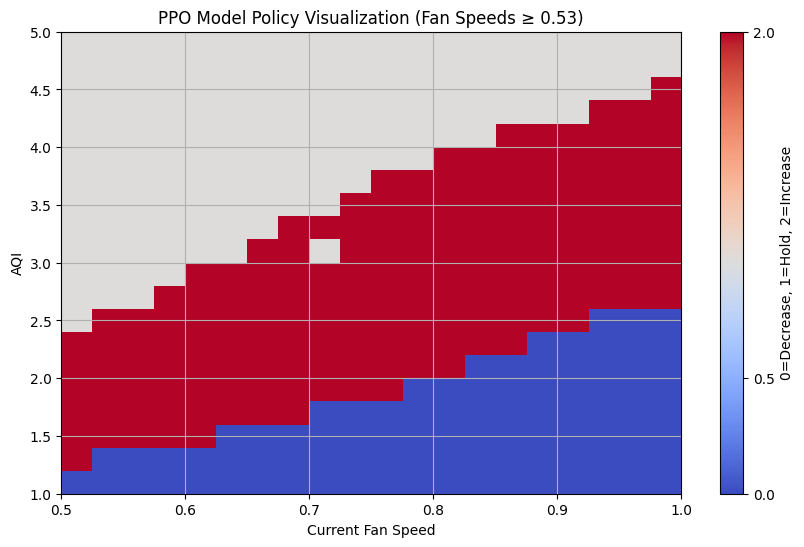

In [212]:
'''
Test with trained model
This script will load the trained model and run it in the environment to see how it performs.
'''

model_ppo = PPO.load(f"{CHECKPOINT_DIR_PPO}/model_100000")  # Path to your saved model
model_dqn = DQN.load(f"{CHECKPOINT_DIR_DQN}/model_100000")  # Path to your saved model
model_a2c = A2C.load(f"{CHECKPOINT_DIR_A2C}/model_100000")  # Path to your saved model
# Evaluate policy
for i, aqi in enumerate(aqi_range):
    for j, speed in enumerate(speed_range):
        obs = np.array([aqi, speed], dtype=np.float32)
        action, _ = model_dqn.predict(obs)
        action_grid[i, j] = action

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(action_grid, extent=[0.5, 1.0, 1, 5], aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(ticks=[0, 0.5, 2], label='0=Decrease, 1=Hold, 2=Increase')
plt.xlabel('Current Fan Speed')
plt.ylabel('AQI')
plt.title('PPO Model Policy Visualization (Fan Speeds ≥ 0.53)')
plt.grid(True)
plt.show()

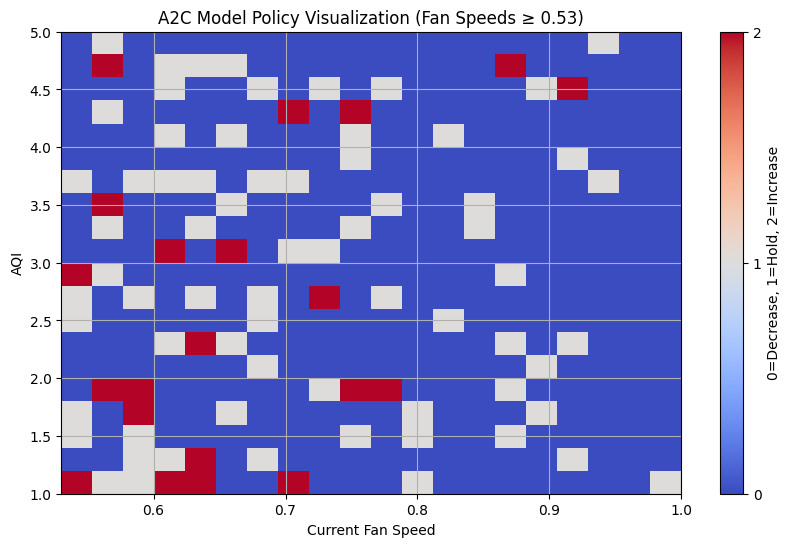

In [207]:
# Evaluate policy
for i, aqi in enumerate(aqi_range):
    for j, speed in enumerate(speed_range):
        obs = np.array([aqi, speed], dtype=np.float32)
        action, _ = model_a2c.predict(obs)
        action_grid[i, j] = action

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(action_grid, extent=[0.53, 1.0, 1, 5], aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(ticks=[0, 1, 2], label='0=Decrease, 1=Hold, 2=Increase')
plt.xlabel('Current Fan Speed')
plt.ylabel('AQI')
plt.title('A2C Model Policy Visualization (Fan Speeds ≥ 0.53)')
plt.grid(True)
plt.show()

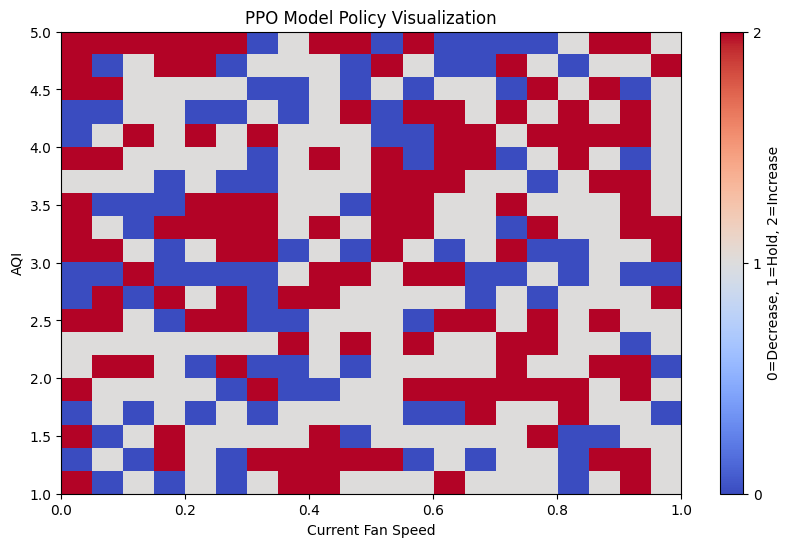

In [208]:
for i, aqi in enumerate(aqi_range):
    for j, speed in enumerate(speed_range):
        obs = np.array([aqi, speed], dtype=np.float32)
        action, _ = model_ppo.predict(obs)
        action_grid[i, j] = action

plt.figure(figsize=(10,6))
plt.imshow(action_grid, extent=[0,1,1,5], aspect='auto', cmap='coolwarm')
plt.colorbar(ticks=[0,1,2], label='0=Decrease, 1=Hold, 2=Increase')
plt.xlabel('Current Fan Speed')
plt.ylabel('AQI')
plt.title('PPO Model Policy Visualization')
plt.show()

In [174]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# --- Load ---
conn = sqlite3.connect("fan_metrics.db")
df = pd.read_sql_query("SELECT * FROM metrics", conn)
conn.close()


In [ ]:
# # Connect to the database
# conn = sqlite3.connect("fan_metrics.db")
# cursor = conn.cursor()

# # Delete rows where algorithm = 'DQN'
# cursor.execute("DELETE FROM metrics WHERE algorithm = ?", ("DQN",))

# # Commit changes and close connection
# conn.commit()
# conn.close()

# print("All data where algorithm = 'DQN' has been deleted.")


All data where algorithm = 'DQN' has been deleted.


In [ ]:

# I assume a linear relationship for voltage estimation
def estimate_voltage(current_fan_speed, min_speed = 0.533, max_voltage=22.5):
    """Estimate voltage based on current fan speed"""
    return current_fan_speed * max_voltage # Simplified to return voltage

def calculate_power(current_fan_speed, voltage, min_speed=0.533, max_rpm=18750, no_load_current=0.5, stall_current=7.0):
    """Calculate motor power draw in watts"""
    # Electrical power = V*I
    effective_speed = (current_fan_speed - min_speed) / (1 - min_speed)
    rpm = effective_speed * max_rpm
    # rpm = self.current_fan_speed * self.max_rpm
    load_factor = min(rpm / max_rpm, 0.95)  # Prevent division by zero
    # Current calculation (simplified motor model)
    current = no_load_current + (stall_current - no_load_current) * (1 - load_factor)
    return voltage * current

def calculate_power(current_fan_speed, min_speed=0.533, max_rpm=18750, no_load_current=0.5, stall_current=7.0, voltage=22.5):
    """Calculate motor power draw in watts"""
    effective_speed = (current_fan_speed - min_speed) / (1 - min_speed)
    rpm = effective_speed * max_rpm
    # rpm = self.current_fan_speed * self.max_rpm
    load_factor = min(rpm / max_rpm, 0.95)  # Prevent division by zero
    # Current calculation (simplified motor model)
    current = no_load_current + (stall_current - no_load_current) * (1 - load_factor)
    return voltage * current


def calculate_reward(current_aqi, target_aqi, current_fan_speed, energy_weight=0.3):
    """Calculate reward balancing AQI and energy use"""
    aqi_error = abs(current_aqi - target_aqi)
    aqi_reward = -aqi_error  # Penalize deviation from target

    # Energy cost using actual power calculation
    energy_cost = energy_weight * (calculate_power(current_fan_speed) / 100)  # Scaled to similar magnitude

    return aqi_reward - energy_cost


In [ ]:
## Recalculate rewards for PPO, DQN, and A2C
df['reward'] = df.apply(lambda row: calculate_reward(row['aqi'], 2.0, row['fan_speed']), axis=1)
df['voltage'] = df['fan_speed'].apply(estimate_voltage)

In [177]:
## Calculate and print the average episode reward for each algorithm
avg_reward = df.groupby("algorithm")["reward"].mean()
for algo, reward in avg_reward.items():
    print(f"Average Episode Reward for {algo}: {reward:.2f}")
# Calculate and print the average fan speed for each algorithm
avg_fan_speed = df.groupby("algorithm")["fan_speed"].mean()
for algo, speed in avg_fan_speed.items():
    print(f"Average Fan Speed for {algo}: {speed:.2f} m/s")
# Calculate and print the average AQI for each algorithm
avg_aqi = df.groupby("algorithm")["aqi"].mean()
for algo, aqi in avg_aqi.items():
    print(f"Average AQI for {algo}: {aqi:.2f}")
# Calculate and print the average TVOC for each algorithm
avg_tvoc = df.groupby("algorithm")["tvoc"].mean()
for algo, tvoc in avg_tvoc.items():
    print(f"Average TVOC for {algo}: {tvoc:.2f} ppb")
# Calculate and print the average eCO2 for each algorithm
avg_eco2 = df.groupby("algorithm")["eco2"].mean()
for algo, eco2 in avg_eco2.items():
    print(f"Average eCO2 for {algo}: {eco2:.2f} ppm")
# Calculate and print the average voltage for each algorithm


Average Episode Reward for A2C: -1.10
Average Episode Reward for DQN: -0.98
Average Episode Reward for PPO: -0.93
Average Episode Reward for ruleBased: -0.83
Average Fan Speed for A2C: 0.11 m/s
Average Fan Speed for DQN: 0.06 m/s
Average Fan Speed for PPO: 0.81 m/s
Average Fan Speed for ruleBased: 0.49 m/s
Average AQI for A2C: 2.33
Average AQI for DQN: 1.25
Average AQI for PPO: 2.79
Average AQI for ruleBased: 2.56
Average TVOC for A2C: 939.00 ppb
Average TVOC for DQN: 85.21 ppb
Average TVOC for PPO: 427.56 ppb
Average TVOC for ruleBased: 467.25 ppb
Average eCO2 for A2C: 822.05 ppm
Average eCO2 for DQN: 455.59 ppm
Average eCO2 for PPO: 781.27 ppm
Average eCO2 for ruleBased: 766.89 ppm



Total Energy Consumed:
   algorithm   energy_J  energy_Wh
0        A2C  245222.55  68.117375
1        DQN  258004.80  71.668000
2        PPO   74373.75  20.659375
3  ruleBased  154899.00  43.027500


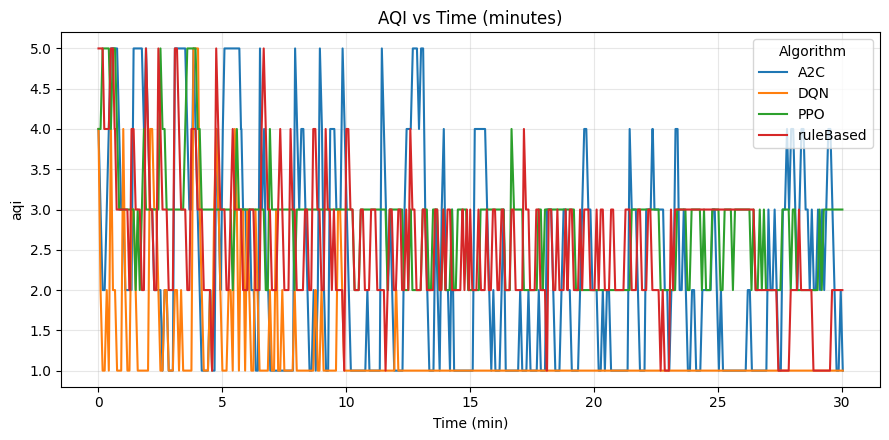

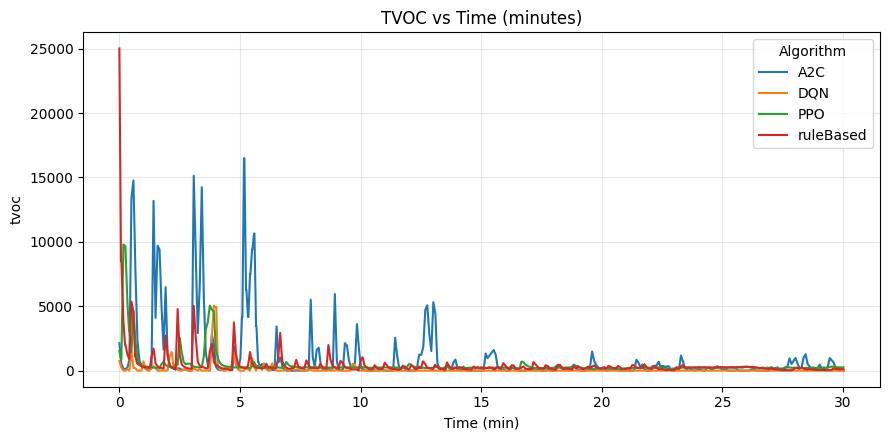

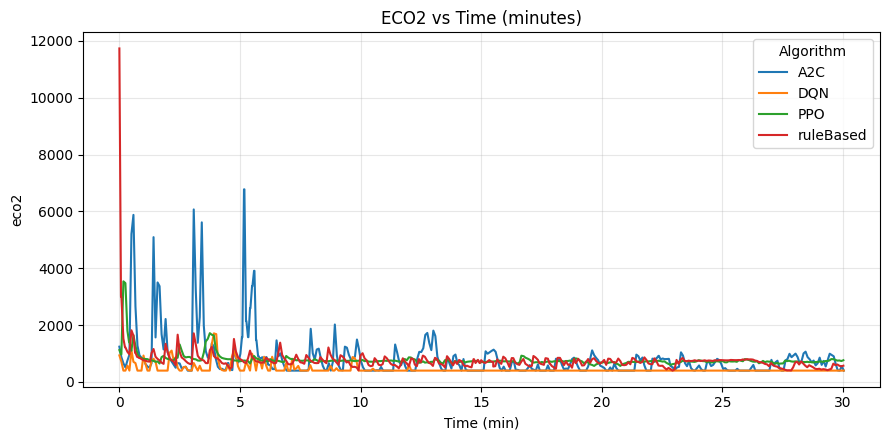

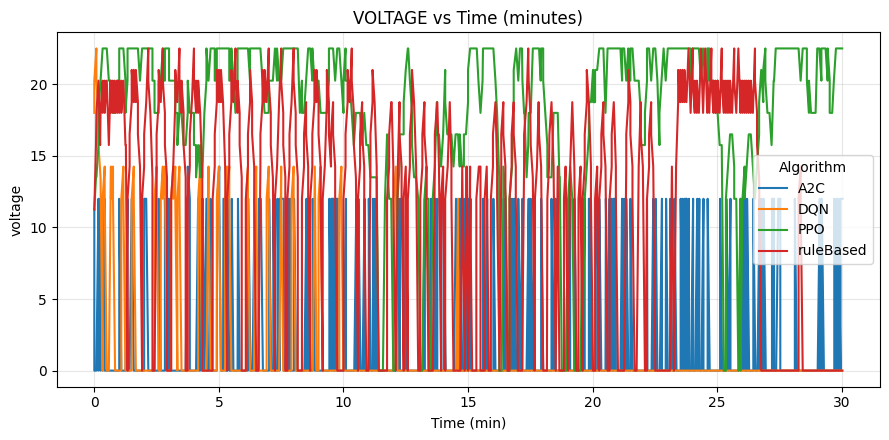

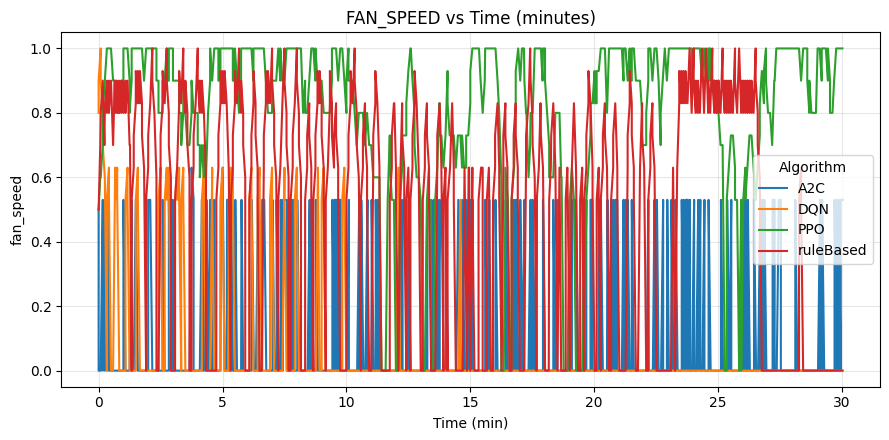

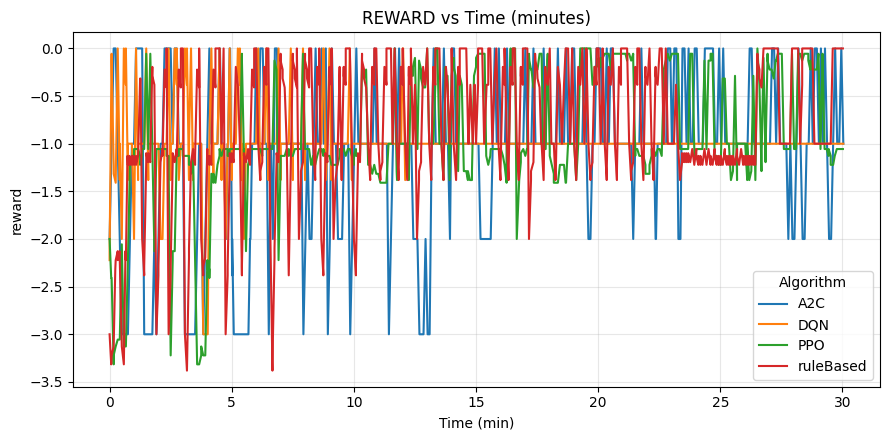

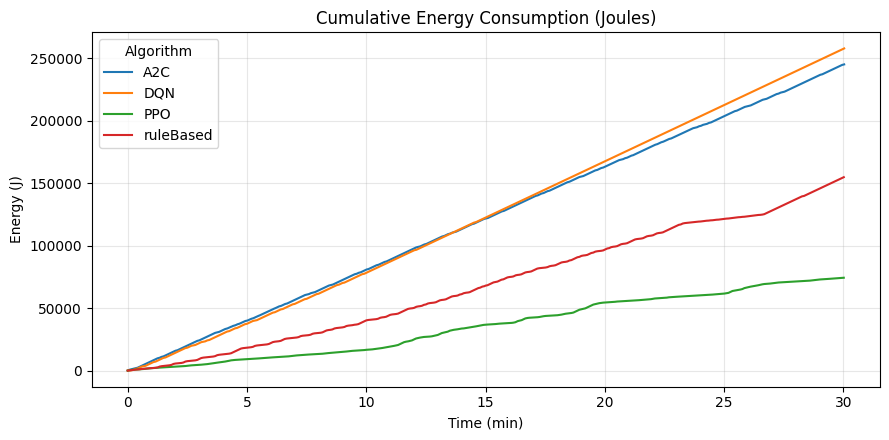

In [ ]:
# --- Ensure time columns exist and are aligned per algorithm ---
if "timestamp" not in df.columns:
    # Fallback: make a synthetic timeline per algorithm at 1s steps
    df["timestamp"] = df.groupby("algorithm").cumcount().astype(float)
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Drop rows with no timestamp
df = df.dropna(subset=["timestamp"]).copy()
df = df.sort_values(["algorithm", "timestamp"]).reset_index(drop=True)

# Per-algorithm time since start (seconds/minutes)
df["t_sec"] = df.groupby("algorithm")["timestamp"].transform(
    lambda s: (s - s.iloc[0]).dt.total_seconds()
)
df["t_min"] = df["t_sec"] / 60.0

# Actual delta time between rows (seconds), per algorithm
df["dt_sec"] = df.groupby("algorithm")["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0)



df["power_W"] = df["fan_speed"].astype(float).apply(calculate_power)
# df['power_W'] = calculate_power(df['fan_speed'],df['voltage'])

# Integrate energy with actual dt (Joules = W * s)
df["energy_J"] = df["power_W"] * df["dt_sec"]

# Total energy per algorithm (J and Wh)
energy_summary = df.groupby("algorithm")["energy_J"].sum().reset_index()
energy_summary["energy_Wh"] = energy_summary["energy_J"] / 3600.0
print("\nTotal Energy Consumed:")
print(energy_summary)

# --- Plot metrics by algorithm ---
metrics = ["aqi", "tvoc", "eco2", "voltage", "fan_speed", "reward"]

def plot_metric(metric):
    plt.figure(figsize=(9, 4.5))
    for algo, g in df.groupby("algorithm"):
        plt.plot(g["t_min"], g[metric], label=str(algo))
    plt.title(f"{metric.upper()} vs Time (minutes)")
    plt.xlabel("Time (min)")
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Algorithm", loc="best")
    plt.tight_layout()
    plt.savefig(f"{metric}_by_algorithm.png", dpi=150)
    plt.show()

for m in metrics:
    if m in df.columns:
        plot_metric(m)

# --- Cumulative energy plot (Joules) ---
plt.figure(figsize=(9, 4.5))
for algo, g in df.groupby("algorithm"):
    plt.plot(g["t_min"], g["energy_J"].cumsum(), label=str(algo))
plt.title("Cumulative Energy Consumption (Joules)")
plt.xlabel("Time (min)")
plt.ylabel("Energy (J)")
plt.grid(True, alpha=0.3)
plt.legend(title="Algorithm", loc="best")
plt.tight_layout()
plt.savefig("cumulative_energy_by_algorithm.png", dpi=150)
plt.show()

In [172]:
def calculate_power(current_fan_speed, min_speed=0.533, max_rpm=18750, no_load_current=0.5, stall_current=7.0, voltage=22.5):
    """Calculate motor power draw in watts"""
    # Electrical power = V*I
    if current_fan_speed < min_speed:
        return 0.0
    effective_speed = (current_fan_speed - min_speed) / (1 - min_speed)
    rpm = effective_speed * max_rpm
    # rpm = self.current_fan_speed * self.max_rpm
    load_factor = min(rpm / max_rpm, 0.95)  # Prevent division by zero
    # Current calculation (simplified motor model)
    current = no_load_current + (stall_current - no_load_current) * (1 - load_factor)
    return voltage * current

In [170]:
TARGET_AQI = 2.0
ENERGY_WEIGHT = 0.3
ACTION_DELTA = 0.1         # matches env step size

# Action mapping: DQN predicts {0,1,2}
ACTION_TO_DELTA = {0: -ACTION_DELTA, 1: 0.0, 2: +ACTION_DELTA}


df["timestamp"] = pd.to_datetime(df.get("timestamp", pd.Series(range(len(df)))), errors="coerce")
df = df.dropna(subset=["timestamp"]).sort_values(["algorithm", "timestamp"]).reset_index(drop=True)

# Filter ruleBased
rb = df[df["algorithm"].astype(str).str.lower() == "rulebased"].copy()
if rb.empty:
    raise ValueError("No ruleBased rows found in DB.")

rb = rb[["timestamp", "aqi"]].sort_values("timestamp").reset_index(drop=True)

# ------------------------------
# Rollout with DQN actions
# ------------------------------
dqn_actions = []
dqn_speed = []
dqn_reward = []
dqn_power = []

In [171]:
# Initialize current fan speed from zero or any seed — here from 1st timestep of ruleBased (e.g., 0.5)
current_speed = 0.5

for i, row in rb.iterrows():
    aqi_t = float(row["aqi"])

    # Observation = [aqi, current_speed]
    obs = np.array([aqi_t, current_speed], dtype=np.float32)
    action, _ = model_dqn.predict(obs, deterministic=True)

    # Update fan speed from action
    delta = ACTION_TO_DELTA[int(action)]
    current_speed = float(np.clip(current_speed + delta, 0.0, 1.0))

    # Compute reward & power
    power = calculate_power(current_speed)
    reward = calculate_reward(aqi_t, TARGET_AQI, current_speed)

    # Log
    dqn_actions.append(int(action))
    dqn_speed.append(current_speed)
    dqn_power.append(power)
    dqn_reward.append(reward)

# Append results
rb["dqn_action"] = dqn_actions
rb["dqn_speed"] = dqn_speed
rb["dqn_power_W"] = dqn_power
rb["dqn_reward"] = dqn_reward

# Energy integration (use timestamp diffs)
rb["dt_sec"] = rb["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0)
rb["dqn_energy_J"] = rb["dqn_power_W"] * rb["dt_sec"]
rb["dqn_energy_Wh"] = rb["dqn_energy_J"] / 3600.0

# ------------------------------
# Summaries
# ------------------------------
print("\n=== DQN evaluation on ruleBased AQI sequence ===")
print(f"Timesteps: {len(rb)}")
print(f"Avg fan speed: {rb['dqn_speed'].mean():.3f}")
print(f"Avg reward: {rb['dqn_reward'].mean():.3f}")
print(f"Total energy: {rb['dqn_energy_Wh'].sum():.4f} Wh")

# # Save for later plotting
# rb.to_csv("ruleBased_with_dqn_results.csv", index=False)
# print("Saved detailed results to ruleBased_with_dqn_results.csv")



=== DQN evaluation on ruleBased AQI sequence ===
Timesteps: 721
Avg fan speed: 0.637
Avg reward: -0.896
Total energy: 32.2038 Wh
